In [ ]:
import sys
sys.path.append('..')
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data.synthetic import Synthetic
from src.randomization_aware.learners import QuasiOptimizedLearner, DRLearner
from sklearn.linear_model import LinearRegression, LogisticRegressionCV

from notebooks.plot_utils import set_default_matplotlib_settings

set_default_matplotlib_settings()

In [5]:
n1 = 100
n0 = 100
population_shift = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
n_features = 3

iterations = 50

rows = []

for shift in population_shift:

    dgp = Synthetic(population_shift=shift, n_features=n_features)

    for i in tqdm(range(iterations)):

        dataset_train = dgp.sample(n1, n0)
        dataset_test = dgp.sample(10_000, 2)
        dataset_test = dataset_test[dataset_test["S"] == 1]

        X_train = dataset_train[dgp.get_covar()].values
        S_train = dataset_train["S"].values.reshape(-1, 1)
        A_train = dataset_train["A"].values.reshape(-1, 1)
        Y_train = dataset_train["Y"].values.reshape(-1, 1)

        X_test = dataset_test[dgp.get_covar()].values
        cate = dataset_test["cate"].values

        models = {
            "DR-learner": DRLearner(
                propensity_score=1 / 2,
                regressor_cate=LinearRegression(),
                regressor_control=LinearRegression(),
                regressor_treated=LinearRegression(),
            ),
            "QR-learner": QuasiOptimizedLearner(
                propensity_score=1 / 2,
                regressor_cate=LinearRegression(),
                regressor_control=LinearRegression(),
                regressor_treated=LinearRegression(),
                study_classifier=LogisticRegressionCV(),
            ),
            "QR-learner without study participation weighting": QuasiOptimizedLearner(
                propensity_score=1 / 2,
                regressor_cate=LinearRegression(),
                regressor_control=LinearRegression(),
                regressor_treated=LinearRegression(),
                remove_study_weighting=True,
                study_classifier=LogisticRegressionCV(),
            ),
        }

        for model_name, model_func in models.items():

            model_func.fit(X_train, S_train, A_train, Y_train)
            predictions = model_func.predict(X_test)
            mse = np.mean((cate - predictions) ** 2)

            rows.append({"model": model_name, "mse": mse, "population_shift": shift})

df = pd.DataFrame(rows)

100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


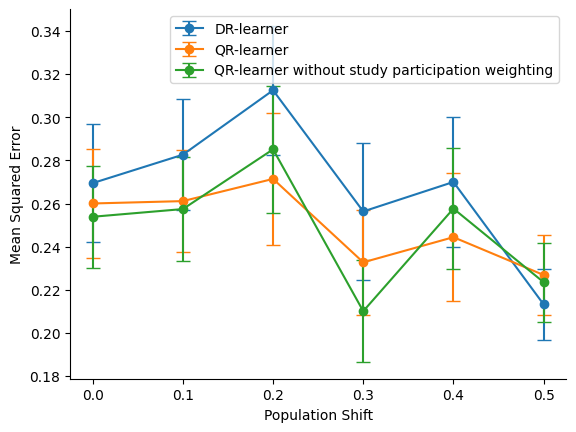

In [ ]:

grouped_df = df.groupby(by=['model', 'population_shift']).agg(['mean', 'sem'])
grouped_df_reset = grouped_df.reset_index()

for model in grouped_df_reset['model'].unique():
    model_data = grouped_df_reset[grouped_df_reset['model'] == model]
    plt.errorbar(
        model_data['population_shift'],
        model_data['mse']['mean'],
        yerr=model_data['mse']['sem'],
        label=model,
        marker='o',
        capsize=5
    )

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Population Shift')
plt.ylabel('Mean Squared Error')
plt.legend()

if not os.path.exists('figures'):
    os.makedirs('figures')

plt.savefig('figures/population_shift_vs_mse.pdf', format='pdf', dpi=300, bbox_inches='tight')
